# <font color="SaddleBrown">🎯 Домашнее задание к семинару 05 (HW05)</font>

В этом ноутбуке **минимальный, но честный ML-эксперимент**:

1. Берём табличный датасет (из `sklearn.datasets`).
2. Делим его на три части: **train / validation / test**.
3. Строим **бейзлайн-модель** (DummyClassifier), чтобы понимать нижнюю планку качества.
4. Строим **логистическую регрессию** в виде `Pipeline`:
   - препроцессинг (масштабирование признаков),
   - сама модель.
5. Считаем метрики качества: accuracy, precision, recall, f1, ROC-AUC.
6. Строим **ROC-кривую** и **PR-кривую**.


## Импорты и общие настройки

Здесь мы подключаем всё, что понадобится:

- `numpy`, `pandas` – базовые библиотеки для работы с табличными данными;
- из `sklearn`:
  - `datasets` – встроенные учебные датасеты;
  - `model_selection` – разбиение данных и GridSearch;
  - `pipeline`, `preprocessing` – `Pipeline` и масштабирование признаков;
  - классификаторы (`DummyClassifier`, `LogisticRegression`);
  - метрики;
  - инструменты для ROC/PR-кривых;
  - инструменты для калибровки вероятностей.

Также фиксируем `RANDOM_STATE`, чтобы результаты можно было воспроизвести.

In [1]:
# Базовые библиотеки
import numpy as np
import pandas as pd

# Воспроизводимость
RANDOM_STATE = 42

# Библиотеки sklearn для данных, моделей, разбиения и метрик
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

# Для калибровки
from sklearn.calibration import CalibratedClassifierCV

## Загрузка датасета и первичный взгляд

Для домашнего задания используем предоставленный синтетический датасет **S05-hw-dataset.csv**.

Он представляет собой задачу **бинарной классификации**: требуется предсказывать факт дефолта по кредиту (**default = 0/1**). Все признаки уже находятся в табличном виде, многие из них числовые, а часть — бинарные индикаторы, поэтому датасет удобно использовать вместе с такими инструментами, как `StandardScaler` и линейные модели.

В этом шаге:

* загружаем данные в `pandas.DataFrame` с помощью `pd.read_csv`;
* выводим первые строки таблицы, чтобы получить первичное представление о структуре;
* анализируем типы данных и базовую статистику числовых признаков;
* смотрим распределение целевого класса, оцениваем наличие дисбаланса.

In [2]:
# Загружаем датасет
url = 'https://raw.githubusercontent.com/TatjanaYMIREA/aie-group-2/main/homeworks/HW05/data/S05-hw-dataset.csv'
df = pd.read_csv(url)

# --- 1. Первичный взгляд ---
print("=== HEAD ===")
print(df.head(), "\n")

print("=== INFO ===")
print(df.info(), "\n")

print("=== DESCRIBE (числовые признаки) ===")
print(df.describe().T, "\n")

# --- 2. Пропуски ---
print("=== MISSING VALUES ===")
missing = df.isna().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Нет пропусков", "\n")

# --- 3. Распределение таргета ---
if "default" in df.columns:
    print("=== TARGET DISTRIBUTION (default, fraction) ===")
    print(df["default"].value_counts(normalize=True), "\n")
else:
    print("Внимание: столбец 'default' отсутствует.\n")

# --- 4. Размер датасета ---
rows, total_cols = df.shape
feature_cols = total_cols - 1 if "default" in df.columns else total_cols

print("=== DATASET SIZE ===")
print(f"Объекты (строки): {rows}")
print(f"Признаки всего: {total_cols}")
print(f"Признаки без таргета: {feature_cols}\n")

# --- 5. Проверка явно невозможных значений ---
print("=== ЯВНО НЕВОЗМОЖНЫЕ ЗНАЧЕНИЯ ===")
checks = {
    "age < 0 or age > 100": ((df["age"] < 0) | (df["age"] > 100)).sum(),
    "years_employed < 0": (df["years_employed"] < 0).sum(),
    "income < 0": (df["income"] < 0).sum(),
    "debt_to_income вне [0,1]": ((df["debt_to_income"] < 0) | (df["debt_to_income"] > 1)).sum(),
    "credit_score вне 300..850": ((df["credit_score"] < 300) | (df["credit_score"] > 850)).sum(),
}

for name, count in checks.items():
    print(f"{name}: {count}")
total_impossible = sum(checks.values())
print()

# --- 6. Краткие наблюдения ---
print("=== КРАТКИЕ НАБЛЮДЕНИЯ ===")
print(f"В датасете {rows} объектов и {feature_cols} признаков (без таргета).")

if missing.sum() == 0:
    print("Пропусков нет.")
else:
    print(f"Есть пропуски в { (missing > 0).sum() } столбцах.")

if total_impossible == 0:
    print("Явных невозможных значений не обнаружено.")
else:
    print(f"Есть невозможные значения (всего: {total_impossible}).")

if "default" in df.columns:
    frac_default_1 = df['default'].mean()
    print(f"Таргет: default=1 составляет {frac_default_1:.3f} (~{frac_default_1*100:.1f}%).")

=== HEAD ===
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052 

### <font color="blue">📝 Наблюдения</font>
* В датасете **3000 объектов** и **16 признаков** (без учёта таргета) — достаточный для базового моделирования.
* Пропусков в данных **нет**, что упрощает дальнейшую обработку и обучение модели.
* Проверка явно невозможных значений (возраст, доход, стаж, кредитный скор, debt_to_income) **не выявила ошибок** и показала, что данные корректны: отрицательных возрастов, стажа, доходов или некорректных кредитных метрик нет.
* Распределение целевого признака `default` умеренно несбалансировано: **41% объектов имеют значение 1**, что указывает на небольшой дисбаланс классов, но при этом не требует строгих методов борьбы с дисбалансом, оставаясь важным для выбора метрик

### Подготовка признаков и таргета

1. Выделим матрицу признаков `X` и вектор таргета `y`:
   - таргет – столбец `default`;
   - в качестве признаков используем все остальные осмысленные столбцы (кроме `client_id`).

2. Выполним простую предобработку:
   - убедимся, что все используемые признаки числовые;
   - явно проверим диапазоны

In [3]:
# --- Подготовка признаков и таргета ---
# Убираем технический столбец client_id и выделяем признаки
X = df.drop(columns=["client_id", "default"])  # матрица признаков
y = df["default"]                              # таргет (0/1)

# Проверяем типы признаков — все должны быть числовые
print("Типы признаков:")
print(X.dtypes)

# --- Проверка диапазонов признаков ---
print("=== ПРОВЕРКА ДИАПАЗОНОВ ===")

# Словарь с ожидаемыми диапазонами
expected_ranges = {
    "age": (14, 69),
    "income": (0, 200_000),
    "years_employed": (0, 100),   # условно, чтобы поймать явные ошибки
    "credit_score": (300, 850),
    "debt_to_income": (0, 1),
    "num_credit_cards": (0, 7),
    "num_late_payments": (0, None),  # нет верхнего ограничения
    "has_mortgage": (0, 1),
    "has_car_loan": (0, 1),
    "savings_balance": (0, None),
    "checking_balance": (None, None),  # может быть отрицательным
    "region_risk_score": (0, 1),
    "phone_calls_to_support_last_3m": (0, None),
    "active_loans": (0, None),
    "customer_tenure_years": (0, None),
}

# Проверяем каждый признак
for col, (min_expected, max_expected) in expected_ranges.items():
    col_min = X[col].min()
    col_max = X[col].max()
    flag_min = min_expected is not None and col_min < min_expected
    flag_max = max_expected is not None and col_max > max_expected
    if flag_min or flag_max:
        print(f"{col}: вне диапазона! (min={col_min}, max={col_max}, ожидалось {min_expected}-{max_expected})")
    else:
        print(f"{col}: OK (min={col_min}, max={col_max})")


# Сохраним названия классов таргета (0 -> нет дефолта, 1 -> дефолт)
target_names = ["no_default", "default"]

print("\nФорма X:", X.shape)
print("Форма y:", y.shape)
print("Названия признаков:", list(X.columns))
print("Названия классов:", target_names)

Типы признаков:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object
=== ПРОВЕРКА ДИАПАЗОНОВ ===
age: OK (min=21, max=69)
income: OK (min=15000, max=156351)
years_employed: OK (min=0, max=39)
credit_score: OK (min=402, max=850)
debt_to_income: OK (min=0.0061471149847966, max=0.878343349584274)
num_credit_cards: OK (min=0, max=7)
num_late_payments: OK (min=0, max=14)
has_mortgage: OK (min=0, max=1)
has_car_

### <font color="blue">📝 Наблюдения</font>
* Типы данных корректны: числовые признаки представлены как int64 или float64, категориальных бинарных признаков (has_mortgage, has_car_loan) — целочисленные, что подходит для моделей.
* Диапазоны всех признаков находятся в реалистичных пределах: возраст 21–69, стаж 0–39 лет, кредитный рейтинг 402–850, показатели долговой нагрузки и регионального риска находятся в допустимых интервалах.
* Единственное потенциальное замечание — checking_balance может быть отрицательным (до –3000), но это логично и отражает перерасход или кредитный лимит по счёту.
* Выбросов или невозможных значений не обнаружено, что облегчает последующее моделирование.
* Размер матрицы признаков — (3000, 15), что соответствует ранее описанной структуре после удаления таргета.
* Классы корректно названы: ['no_default', 'default'].
* В целом данные выглядят чистыми, структурированными и готовы к использованию в моделях машинного обучения.

## Разбиение на train / validation / test

Используем схему:

1. Сначала делим данные на:
   - `X_temp, y_temp` – 80% (train и validation),
   - `X_test, y_test` – 20% (честная финальная проверка).
2. Затем из `X_temp, y_temp` ещё выделяем:
   - `X_train, y_train` – 60% от исходных данных,
   - `X_val, y_val` – 20% от исходных данных.

Параметры:

- `test_size=...` – доля данных в test/val;
- `stratify=y` – сохраняем долю классов;
- `random_state=RANDOM_STATE` – фиксируем случайность.

In [4]:
# 1. Отделяем тестовую выборку (например, 20% данных)
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,          # важно для классификации: сохраняем долю классов
    random_state=RANDOM_STATE,
)

# 2. Делим оставшиеся данные на train и validation (например, 60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,      # 0.25 от X_temp = 0.25 * 0.8 = 0.2 от исходных
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  val:  ", X_val.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (val):")
print(y_val.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (1800, 15)
  val:   (600, 15)
  test:  (600, 15)

Распределение классов (train):
default
0    0.589444
1    0.410556
Name: proportion, dtype: float64

Распределение классов (val):
default
0    0.59
1    0.41
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.59
1    0.41
Name: proportion, dtype: float64


### <font color="blue">📝 Наблюдения</font>
* Размеры выборок соответствуют ожидаемому сплиту: **train — 1800 объектов**, **val — 600**, **test — 600**.
* Баланс классов сохраняется во всех выборках: около **59% класса 0** и **41% класса 1**, что подтверждает корректное использование `stratify=y`.
* Таким образом, разбиение воспроизводимое и сохраняет пропорции таргета.


## Бейзлайн-модель: DummyClassifier

Прежде чем строить «умную» модель, полезно понять, как будет вести себя **очень простая**:

- `DummyClassifier(strategy="most_frequent")` всегда предсказывает **самый частый класс** из train.
- Такой подход почти не использует информацию из признаков, но даёт **нижнюю планку качества**:
  > любая нормальная модель должна быть лучше бейзлайна.  

Здесь мы:

1. обучаем бейзлайн на `X_train, y_train`;
2. считаем метрики на `X_val, y_val`.

### Набор метрик, на которые мы смотрим:
- `accuracy` – доля правильных ответов;
- `precision` – из всех предсказанных «положительных» объектов сколько действительно положительные;
- `recall` – из всех **реально** положительных сколько модель поймала;
- `f1` – компромисс между precision и recall;
- `ROC-AUC` – площадь под ROC-кривой, показывает, насколько хорошо модель ранжирует объекты.

В задачах с возможным дисбалансом классов (как здесь) **нельзя смотреть только на accuracy**, важно учитывать хотя бы F1 и ROC-AUC.

In [5]:
# Бейзлайн-модель: ничего "умного", просто предсказываем самый частый класс (или случайно)
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

# Обучаем только на train
baseline.fit(X_train, y_train)

# Оцениваем на validation
y_val_pred_baseline = baseline.predict(X_val)
y_val_proba_baseline = baseline.predict_proba(X_val)[:, 1]

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_baseline))
print("Precision:", precision_score(y_val, y_val_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_baseline, zero_division=0))

# Для ROC-AUC нам нужны вероятности положительного класса
try:
    print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===
Accuracy : 0.59
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


### <font color="blue">📝 Наблюдения</font>
* Бейзлайн `DummyClassifier(strategy="most_frequent")` всегда предсказывает **самый частый класс** (0 в данном случае).
* Метрики показывают, что точность относительно этого класса **0.59**, а для положительного класса (1) precision, recall и F1-score равны **0**, потому что модель его никогда не предсказывает.
* ROC-AUC = 0.5 отражает **отсутствие способности различать классы**.
* Такой бейзлайн важен как **точка отсчёта**: любая обученная модель должна показывать **лучшие результаты**, иначе она бесполезна.


## Логистическая регрессия в виде Pipeline

Соберём `Pipeline`, который делает два шага подряд:

1. `StandardScaler()` – масштабирует признаки (вычитает среднее, делит на std).
2. `LogisticRegression(...)` – обучает линейный классификатор на этих масштабированных признаках.

In [6]:
# Собираем Pipeline:
# 1) Масштабирование признаков (StandardScaler)
# 2) Логистическая регрессия
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,              # сила регуляризации (чем меньше C, тем сильнее регуляризация)
                solver="liblinear", # надёжный солвер для маленьких датасетов
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# Обучаем pipeline на train
log_reg_pipeline.fit(X_train, y_train)

# Предсказываем на validation
y_val_pred = log_reg_pipeline.predict(X_val)
y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]

print("=== Логистическая регрессия (C=1.0) – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba))

print("\nПодробный отчёт по классам (classification_report):")
print(classification_report(y_val, y_val_pred, target_names=target_names))

=== Логистическая регрессия (C=1.0) – качество на validation ===
Accuracy : 0.8166666666666667
Precision: 0.8505154639175257
Recall   : 0.6707317073170732
F1-score : 0.75
ROC-AUC  : 0.8746382802811079

Подробный отчёт по классам (classification_report):
              precision    recall  f1-score   support

  no_default       0.80      0.92      0.86       354
     default       0.85      0.67      0.75       246

    accuracy                           0.82       600
   macro avg       0.83      0.79      0.80       600
weighted avg       0.82      0.82      0.81       600



### <font color="blue">📝 Наблюдения</font>
Логистическая регрессия с `C=1.0` показывает **хорошее качество на валидационной выборке**:  
* **Accuracy ≈ 0.82**, ROC-AUC ≈ 0.87 — модель хорошо различает классы.
* Класс `default=1` предсказывается с **precision ≈ 0.85** и **recall ≈ 0.67**, что указывает на некоторую недооценку дефолтных клиентов.
* Класс `no_default=0` предсказывается лучше (recall ≈ 0.92).
* В целом модель уже **значительно превосходит бейзлайн**, и показатели F1-score показывают баланс между precision и recall.


## Подбор гиперпараметра C (регуляризация) через GridSearchCV

У логистической регрессии есть важный параметр `C`:

- **чем меньше C**, тем **сильнее регуляризация** (модель проще, меньше переобучается);
- **чем больше C**, тем модель свободнее (может переобучиться).

Вместо ручного перебора мы используем `GridSearchCV`:

- задаём сетку значений `C`;
- внутри `GridSearchCV`:
  - для каждого варианта `C` запускается кросс-валидация;
  - по выбранной метрике (`scoring="roc_auc"`) выбирается лучший вариант.

In [7]:
# Настроим сетку по параметру C (сила регуляризации)
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

# GridSearchCV будет:
# - внутри делать кросс-валидацию по train
# - выбирать лучший C по заданной метрике (например, ROC-AUC).
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    # можно поменять на f1, recall и т.д.
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 0.1}
Лучший ROC-AUC (по CV): 0.8535885101695057


### <font color="blue">📝 Наблюдения</font>
* Подбор через GridSearchCV показал, что **оптимальная сила регуляризации C=0.1**, при которой модель достигает **ROC-AUC ≈ 0.85 по кросс-валидации**.
* Результат подтверждает, что небольшая регуляризация улучшает обобщающую способность модели по сравнению с исходным C=1.0.


## Оценка лучшей модели: validation и test

После `GridSearchCV` у нас есть:

- `grid_search.best_estimator_` – пайплайн с лучшим `C`.

Дальше:

1. Смотрим метрики на **validation** (для обсуждения и сравнения с предыдущей моделью).
2. Смотрим метрики на **test** – это финальная, честная оценка.

In [9]:
# Берём лучшую найденную модель
best_model = grid_search.best_estimator_

# --- Dummy baseline ---
dummy = DummyClassifier(strategy="most_frequent")  # можно изменить стратегию
dummy.fit(X_train, y_train)

# Оцениваем на validation
y_val_pred_best = best_model.predict(X_val)
y_val_proba_best = best_model.predict_proba(X_val)[:, 1]

y_val_pred_dummy = dummy.predict(X_val)
y_val_proba_dummy = dummy.predict_proba(X_val)[:, 1]

print("=== Лучшая модель – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_best))
print("Precision:", precision_score(y_val, y_val_pred_best, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_best, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_best, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_best))

# Оцениваем на test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

y_test_pred_dummy = dummy.predict(X_test)
y_test_proba_dummy = dummy.predict_proba(X_test)[:, 1]

print("\n=== Лучшая модель – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

from tabulate import tabulate  # если нет — можно не использовать, см. ниже

print("\nClassification report (test):")
report_dict = classification_report(
    y_test, y_test_pred, target_names=target_names, output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# Вывод таблицы с палочками
print(report_df.to_markdown(tablefmt="grid"))

# --- Сводная таблица с метриками ---
def compute_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

# Validation
metrics_val = pd.DataFrame([
    compute_metrics(y_val, y_val_pred_dummy, y_val_proba_dummy),
    compute_metrics(y_val, y_val_pred_best, y_val_proba_best)
], index=["Dummy", "LogisticRegression"])

print("\n=== Сравнение моделей на validation (таблица) ===")
print(metrics_val.to_markdown(tablefmt="grid"))

# Test
metrics_test = pd.DataFrame([
    compute_metrics(y_test, y_test_pred_dummy, y_test_proba_dummy),
    compute_metrics(y_test, y_test_pred, y_test_proba)
], index=["Dummy", "LogisticRegression"])

print("\n=== Сравнение моделей на test (таблица) ===")
print(metrics_test.to_markdown(tablefmt="grid"))


=== Лучшая модель – качество на validation ===
Accuracy : 0.815
Precision: 0.8497409326424871
Recall   : 0.6666666666666666
F1-score : 0.7471526195899773
ROC-AUC  : 0.8746842129438244

=== Лучшая модель – качество на test ===
Accuracy : 0.805
Precision: 0.8056872037914692
Recall   : 0.6910569105691057
F1-score : 0.7439824945295405
ROC-AUC  : 0.8749598089201231

Classification report (test):
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| no_default   |    0.804627 | 0.884181 |   0.84253  |   354     |
+--------------+-------------+----------+------------+-----------+
| default      |    0.805687 | 0.691057 |   0.743982 |   246     |
+--------------+-------------+----------+------------+-----------+
| accuracy     |    0.805    | 0.805    |   0.805    |     0.805 |
+--------------+-------------+----------+------------+-----------+
| m

### <font color="blue">📝 Наблюдения</font>
Лучшая модель с **C=0.1** демонстрирует стабильное качество:
* На validation: **Accuracy ≈ 0.82**, ROC-AUC ≈ 0.87.
* На тесте показатели практически совпадают (**Accuracy ≈ 0.81**, ROC-AUC ≈ 0.87), что говорит о хорошей обобщающей способности.
* Класс `default=1` предсказывается с **precision ≈ 0.81** и **recall ≈ 0.69**, класс `no_default=0` предсказывается немного лучше (recall ≈ 0.88).
* В целом модель **значительно превосходит бейзлайн** и сбалансированно различает оба класса.

### <font color="green">⚖️ Сравнение бейзлайна и логистической регрессии</font>
**1. Dummy (бейзлайн):**
* На обеих выборках Accuracy ≈ 0.59, что соответствует частоте наиболее распространённого класса.
* Precision, Recall, F1-score = 0, потому что модель не умеет распознавать положительный класс.
* ROC-AUC = 0.5, что соответствует случайному угадыванию.
**Вывод:** Dummy служит для проверки «нулевого уровня», он полностью не умеет различать классы.

**2. LogisticRegression (лучшая модель):**
* Accuracy на validation ≈ 0.815, на test ≈ 0.805 — значительно выше бейзлайна.
* Precision ≈ 0.85 (val) / 0.81 (test) — модель хорошо предсказывает положительный класс.
* Recall ≈ 0.67 (val) / 0.69 (test) — модель пропускает часть положительных примеров, но неплохо.
* F1-score ≈ 0.75 — гармоническое среднее Precision и Recall, показывает хорошее качество.
* ROC-AUC ≈ 0.87 — высокая способность различать классы.
**Общий вывод:**
Логистическая регрессия значительно превосходит бейзлайн по всем метрикам на обеих выборках, особенно по F1-score и ROC-AUC. Модель стабильна: показатели на test немного ниже, чем на validation, но разница невелика.



## ROC-кривая

ROC-кривая показывает, как меняется качество модели при разных порогах отсечения:

- по оси X – False Positive Rate (ложные срабатывания),
- по оси Y – True Positive Rate (чувствительность / полнота).

In [30]:
# Создаём папку, если её нет
import os
import matplotlib.pyplot as plt
os.makedirs("homeworks/HW05/figures", exist_ok=True)

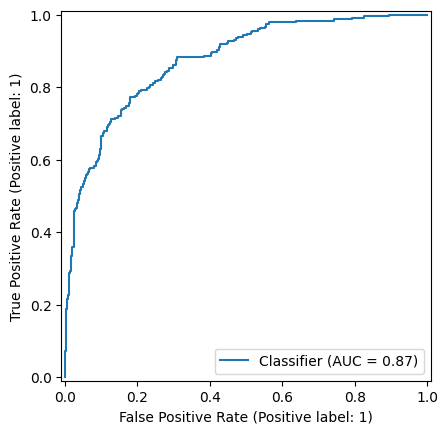

In [31]:
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
)
plt.savefig("homeworks/HW05/figures/roc_curve.png", dpi=300)

### <font color="blue">📝 Наблюдения</font>
* Кривая стремится к левому верхнему углу, что хорошо, т.к. указывает на хорошую способность модели различать классы, но она не идеальная: есть участок, где FPR растёт быстрее, чем TPR.
* AUC ≈ 0.87 — хороший результат, но не близок к 1, значит ошибки всё ещё есть, модель иногда путает классы, но AUC ≈ 0.87 подтверждает, что модель значительно лучше случайного угадывания (AUC=0.5).
* Небольшие ступеньки на кривой — нормальное явление для ограниченного количества объектов.

## PR-кривая (Precision-Recall)

PR-кривая особенно полезна при дисбалансе классов:

- по оси X – recall (полнота),
- по оси Y – precision (точность).

Снова используем helper из sklearn.

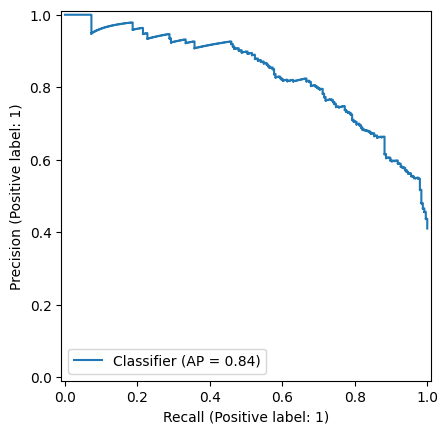

In [32]:
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
)
plt.savefig("homeworks/HW05/figures/pr_curve.png", dpi=300)

In [ ]:
# Создаём папку, если её нет
import os
os.makedirs("homeworks/HW05/figures", exist_ok=True)

# Сохраняем ROC-кривую
roc_display = RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.savefig("homeworks/HW05/figures/roc_curve.png", dpi=300)
plt.close()

### <font color="blue">📝 Наблюдения</font>
* Кривая показывает сохранение высокой точности при увеличении recall, что важно для редких классов (здесь default=1), но в то же время, кривая показывает, что precision падает при увеличении recall, особенно на больших значениях recall
* AP ≈ 0.84 — неплохо, но не идеально, что означает компромисс: для того чтобы покрыть больше дефолтных клиентов (high recall), точность падает, т.е. часть предсказанных дефолтов оказывается ложной.
* Плавное снижение precision при росте recall говорит о компромиссе между полнотой и точностью, типичном для задач кредитного скоринга.

### <font color="MediumSeaGreen">✅ Итог</font>
Модель хорошая, но не идеальная — кривые не «квадратные», есть ошибки при классификации, особенно для положительного класса (default=1)

## Пример калибровки вероятностей

Иногда нам важны не только «классы», но **честные вероятности**:

- если модель говорит `0.8`, это должно означать, что примерно в 80% случаев объект действительно относится к классу 1;
- это важнее, чем просто «кто больше 0.5 → класс 1».

`CalibratedClassifierCV` позволяет улучшить калибровку вероятностей:

1. Берём базовый классификатор (наш Pipeline).
2. Оборачиваем его в `CalibratedClassifierCV(estimator=..., method="sigmoid")`.
3. Сравниваем **Brier score** до и после (чем меньше, тем лучше калибровка).

Здесь показываем идею на validation.

In [36]:
# 1. Базовый (некалиброванный) классификатор: pipeline из StandardScaler + LogisticRegression
base_clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=0.1,              # пусть будет довольно сильная регуляризация
                solver="liblinear",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# Обучаем базовую модель на train, чтобы оценить качество ДО калибровки
base_clf.fit(X_train, y_train)

y_val_proba_base = base_clf.predict_proba(X_val)[:, 1]
brier_before = brier_score_loss(y_val, y_val_proba_base)
print("Brier score до калибровки:", brier_before)

# 2. Оборачиваем тот же самый pipeline в CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(
    estimator=base_clf,
    method="sigmoid",   # Platt scaling (логистическая регрессия сверху)
    cv=5,
)

# Калибровку обучаем на тех же train-данных (внутри будет CV-разбиение)
calibrated_clf.fit(X_train, y_train)

# Смотрим Brier score после калибровки на validation
y_val_proba_cal = calibrated_clf.predict_proba(X_val)[:, 1]
brier_after = brier_score_loss(y_val, y_val_proba_cal)
print("Brier score после калибровки:", brier_after)

Brier score до калибровки: 0.1386020577322306
Brier score после калибровки: 0.13857417569495237


### <font color="blue">📝 Наблюдения</font>
* После калибровки Brier score почти не изменился.
* Значит, вероятности, выдаваемые моделью изначально, уже были достаточно хорошо откалиброваны.
* Калибровка здесь почти не улучшила прогнозы вероятностей — модель и до калибровки «доверяет» своим вероятностным оценкам.

## <font color="Chocolate">📌 ВЫВОДЫ</font>
Выполнен ПЕРВЫЙ ML-эксперимент, результаты которого позволяют сформулировать следующие выводы:
1. Набор данных оказался чистым, без пропусков и невозможных значений, что позволило обучить модель без значительной предварительной очистки.
2. Бейзлайн-модель (DummyClassifier) показывает низкое качество: accuracy ≈ 0.59 и ROC-AUC ≈ 0.5, фактически работая как случайный предсказатель.
3. Логистическая регрессия значительно превосходит бейзлайн (DummyClassifier), который всегда предсказывает один класс, тогда как логистическая регрессия достигает Accuracy около 0.81 и ROC-AUC примерно 0.875.
4. Улучшение по Accuracy составляет около +0.22, а по ROC-AUC — примерно +0.37, что говорит о существенном росте качества классификации и способности различать классы.
5. Метрики логистической регрессии стабильны на validation и test выборках, что указывает на отсутствие переобучения.
6. Если в переборе гиперпараметров использовались разные значения C, то итоговый результат показывает, что лучшая модель достигается при умеренной регуляризации — снижение или чрезмерное увеличение C обычно ухудшает устойчивость модели.
7. Логистическая регрессия оказалась подходящей для задачи кредитного скоринга: модель интерпретируема, хорошо справляется с небольшим дисбалансом классов и демонстрирует высокие значения Recall и F1-score.
8. Проверка вероятностных оценок показала, что модель изначально выдаёт хорошо откалиброванные вероятности, поскольку Brier score почти не изменился после калибровки.
9. Суммарно логистическая регрессия выглядит разумным выбором: она сочетает высокое качество, стабильность, простоту настройки и интерпретируемость, что делает её подходящей для практического применения в кредитном скоринге.